 As we have seen in our 1st notebook that our model, ResNet-50 built from scratch, didnt perform well due to imbalanced training dataset.

 So in **this notebook** we'll experiment with the below tactics to handle the imbalanced dataset:

* Explore **data augmentation** alongwith **custom augmentation** of the images to help the model generalize better.

* We'll also finetune it by:
  * increasing the number of epochs to 100
  * increasing the batch size to 32
  * changing the learning rate to 1e-3
  * replacing dropout with **regularization**

We'll then again train our model on the custom dataset, and find out how it performs on our test dataset.

In [ ]:
#!pip install torchvision

In [ ]:
import tensorflow_datasets as tfds
import logging
from zipfile import ZipFile
import os
import sys
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from utils.events import download_google_drive_file

In [ ]:
import os
os.listdir('/kaggle/input/deepweeds-image-classification')


['train_subset1.csv',
 'test_subset1.csv',
 'val_subset0.csv',
 'test_subset0.csv',
 'train_subset0.csv',
 'images',
 'val_subset1.csv',
 'labels.csv']

In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision import transforms
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim

## Applying Data Augmentation:

Let's apply **data augementation** on the images in a new folder named `images_new`. We did this on colab notebook and then uploaded the 'new folder' on 'Kaggle' while running the model. We'll also update the csv file.

*NB: After applying the augmentation & saving them in a new folder, we'll comment them out as we wouldnt need it again while rerunning this notebook.*

In [ ]:
# # Applying Data Augmentation code to 'augment' the images

# import os
# from PIL import Image
# import pandas as pd
# import torch
# from torchvision import transforms

# # Load the CSV file and filter out images with labels 0-7
# data = pd.read_csv('images/train_subset0.csv')
# filtered_data = data[data['Label'].between(0, 7)]        # Filter for labels between 0 and 7

# # Define the image folder and augmentation transformations
# #image_folder = '/kaggle/input/deepweeds-image-classification/images'  # Update with your image folder path
# image_folder_new = "/content/drive/My Drive/Agri Project/images_new"  # Update with your image folder path   # Path for augmented images
# image_folder = "/content/drive/My Drive/Agri Project/images"      # Path for original images

# ## Augmentation Transformations: The transformations create variety in the dataset to improve model generalization.
# augmentations = transforms.Compose([
#     transforms.RandomRotation(degrees=360),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),
#     transforms.RandomHorizontalFlip(p=0.5),
# ])

# ## Augmentation Loop:
# new_data = []  # list to hold new data for updating the CSV

# # Loop through each image and apply augmentations
# for index, row in filtered_data.iterrows():
#     image_path = os.path.join(image_folder, row['Filename'])
#     image = Image.open(image_path)

#     # Apply augmentations
#     for i in range(4):  # Generate 4 augmented images for each original image
#         augmented_image = augmentations(image)   # Apply transformations

#         # Create a new filename for the augmented image & Save the augmented image with a new filename
#         new_filename = f"aug_{i}_{row['Filename']}"
#         new_image_path = os.path.join(image_folder_new, new_filename)

#         # Save the augmented image
#         augmented_image.save(new_image_path)

#         # Append the new image and label to the new data
#         new_data.append({'Filename': new_filename, 'Label': row['Label']})

# ## Update CSV File:
# # Add new data to the original dataframe
# augmented_df = pd.DataFrame(new_data)
# updated_data = pd.concat([data, augmented_df], ignore_index=True)    # Merge with original data

# # Save the updated CSV
# updated_data.to_csv('images_new/train_subset0_augmented.csv', index=False)
#    # Now the new CSV includes both original and augmented images.

# print("Augmentation complete and CSV updated.")

KeyboardInterrupt: 

Also let's **copy all the images** from the `image` folder to `images_new` folder to be used for testing the model.

*NB: After copying them in the new folder, we'll comment them out as we wouldnt need it again while rerunning this notebook.*

In [ ]:
# # Copying images from  from 'image' folder to 'images_new' folder

# import os
# import shutil

# # Define source and destination folders
# source_folder = '/content/drive/My Drive/Agri Project/images'       # The directory containing the original image files.
# destination_folder = '/content/drive/My Drive/Agri Project/images_new'     # The directory where the images will be copied.

# # Create the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# # Loop through all files in the source folder
# for filename in os.listdir(source_folder):
#     # Check if the file is an image (modify the extensions as needed)
#     if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')):
#         # Construct full file paths
#         source_path = os.path.join(source_folder, filename)
#         destination_path = os.path.join(destination_folder, filename)
#         # Copy the file
#         shutil.copy(source_path, destination_path)
#         print(f"Copied {filename} to {destination_folder}")

# print("All images have been copied.")

Streaming output truncated to the last 5000 lines.
Copied 20170920-164757-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-164822-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-164843-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-164855-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-164910-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-164924-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-165451-1.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-165507-1.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-165528-1.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-171010-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-171023-3.jpg to /content/drive/My Drive/Agri Project/images_new
Copied 20170920-171035-3.jpg to /content/drive/My Drive/Agri Project/

## Applying Custom Augmentation:

**Below code snippet** implements a more sophisticated and customizable data augmentation pipeline compared to the above one.

It integrates both **PyTorch's transforms** and **custom OpenCV-based transformations** for augmenting images. Additionally, it includes a custom dataset class and creates data loaders to handle images and labels efficiently for training, validation, and testing.

In [ ]:
## Custom OpenCV-Based Augmentation:

import torch
import torchvision.transforms as transforms
import random
import cv2
import numpy as np
from PIL import Image

# Define a custom augmentation function for OpenCV transformations
def random_perspective(img):
    """Apply random perspective transformation using OpenCV."""
    h, w = img.shape[:2]
    #Define the perspective transformation
    src_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
    dst_pts = np.float32([[random.uniform(-0.1, 0.1) * w, random.uniform(-0.1, 0.1) * h] for _ in range(4)])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    img = cv2.warpPerspective(img, matrix, (w, h))
    return img

# Function to perform augmentations including OpenCV-based perspective shift
class CustomAugmentations:
    def __init__(self):
        # Define transformations from torchvision.transforms
        self.transforms = transforms.Compose([
            transforms.Resize((128, 128)),  # Resize all images to 256x256
            transforms.RandomRotation(degrees=360),  # Rotate randomly within [-360, +360]
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),  # Color shifts
            transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
        ])

    def __call__(self, img):
        # Convert PIL image to OpenCV format (numpy array)
        img = np.array(img)
        # Perform random perspective transformation using OpenCV
        img = random_perspective(img)
        # Convert back to PIL image for further processing
        img = Image.fromarray(img)
        # Apply remaining torchvision transformations
        img = self.transforms(img)
        # Convert the image to a tensor
        img = transforms.ToTensor()(img)
        # Pixel intensity shift [-25, +25] and scaling [0.75, 1.25]
        img = self.random_pixel_intensity_shift(img)

        return img

    def random_pixel_intensity_shift(self, img):
        """Shift pixel intensity uniformly across all channels and scale within [0.75, 1.25]."""
        # Pixel intensity shift in range [-25, +25]
        intensity_shift = random.uniform(-25 / 255.0, 25 / 255.0)
        img = torch.clamp(img + intensity_shift, 0, 1)
        # Pixel intensity scaling in range [0.75, 1.25]
        intensity_scale = random.uniform(0.75, 1.25)
        img = torch.clamp(img * intensity_scale, 0, 1)

        return img

# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


train_csv_file = '/kaggle/input/images-new/images_new/train_subset0_augmented.csv'  # Replace with your actual path
test_csv_file = '/kaggle/input/deepweeds-image-classification/test_subset0.csv'  # Replace with your actual path
val_csv_file = '/kaggle/input/deepweeds-image-classification/val_subset0.csv'  # Replace with your actual path
img_dir= '/kaggle/input/images-new/images_new'


# Image transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing to 128x128, you can adjust this
    transforms.RandomRotation(degrees=360),  # Rotate randomly within [-360, +360]
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0),  # Color shifts
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])

# Create an instance of the custom augmentations
custom_augmentations = CustomAugmentations()

# Create the train and test datasets
train_dataset = ImageDataset(csv_file=train_csv_file, img_dir=img_dir, transform=transform)
test_dataset = ImageDataset(csv_file=test_csv_file, img_dir=img_dir, transform=transform)
val_dataset = ImageDataset(csv_file=val_csv_file, img_dir=img_dir, transform=transform)


# Create DataLoaders for batching
def create_dataloader(loader_type):
  if loader_type=='train':
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)     # Increasing the batch size to 32 from 16
    print(f"len train_loader {len(train_loader)}")
    return train_loader
  elif loader_type=='val':
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_loader
  else:
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return test_loader


# Applying the ResNet-50 Model built from scratch:-

Let us now apply our ResNet-50 model built from scratch (as in our 1st notebook) without the 'dropout rate'.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Bottleneck(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channel = 64
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, out_channel, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != out_channel * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, out_channel * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel * 4)
            )

        layers = []
        layers.append(block(self.in_channel, out_channel, stride, downsample))
        self.in_channel = out_channel * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channel, out_channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Adjusted resnet50 function with FC layer mismatch handling
def resnet50(pretrained=False, num_classes=9, **kwargs):
    model = ResNet50(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, **kwargs)

    if pretrained:
        # Load the pretrained ResNet50 model from torchvision
        pretrained_model = models.resnet50(pretrained=True)

        # Load pretrained state dict, but ignore the weights for the fully connected (fc) layer
        pretrained_dict = pretrained_model.state_dict()
        model_dict = model.state_dict()

        # Filter out the FC layer weights from the pretrained model
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc' not in k}

        # Load the state dict, ignoring the mismatched FC layer
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

    # Replace the FC layer with a custom one that matches num_classes
    model.fc = nn.Linear(512 * 4, num_classes)

    return model


# Instantiate the model with 9 output classes
model = resnet50(pretrained=False, num_classes=9)
print(model)


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

# Model Compilation and Training:-

Below we'll implement the training and validation loop for a ResNet50 model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Loss Function and Optimizer Setup:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)    # Changing the learning rate to le-3 from le-4

# Training History and Device Setup:
history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

best_val_accuracy = 0.0
best_model_path = "/kaggle/working/best_model_aug.pth"

# Applying regualrization:
lambda_l1 = 0.0001        # Regularization strength for L1
lambda_l2 = 0.0001        # Regularization strength for L2

model = model.to(device)

# Dataloaders:
train_loader = create_dataloader(loader_type='train')
val_loader = create_dataloader(loader_type='val')

# Training Loop:
for epoch in range(100):            # Increasing the # of epochs to 100 from 25
          model.train()
          running_loss = 0.0
          train_correct = 0
          train_total = 0
          for i, (inputs, targets) in enumerate(train_loader):
              inputs, targets = inputs.to(device), targets.to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, targets
              loss.backward()
              optimizer.step()
              #training metrics
              running_loss += loss.item()
              train_total += targets.size(0)
              train_correct += predicted.eq(targets).sum().item()

              if i % 100 == 0:
                  print(f'Epoch [{epoch+1}/100], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

          #training metrics-
          train_loss = running_loss / len(train_loader)
          train_accuracy = train_correct / train_total
          history['train_loss'].append(train_loss)
          history['train_accuracy'].append(train_accuracy)

          # Validation Loop:
          model.eval()
          val_loss = 0.0
          val_correct = 0
          val_total = 0
          with torch.no_grad():
            for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, predicted)

              val_loss += loss.item()
              val_total += targets.size(0)
              val_correct += predicted.eq(targets).sum().item()

          # Calculate accuracy
          val_loss /= len(val_loader)
          val_accuracy = val_correct / val_total
          history['val_loss'].append(val_loss)
          history['val_accuracy'].append(val_accuracy)

          print(f'Epoch [{epoch+1}/100], Validation Accuracy: {val_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}')

          # Save Best Model / Model Checkpointing:
          if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with Validation Accuracy: {val_accuracy:.4f}")




len train_loader 958
Epoch [1/100], Step [1/958], Loss: 1.0609
Epoch [1/100], Step [101/958], Loss: 0.6610
Epoch [1/100], Step [201/958], Loss: 1.0816
Epoch [1/100], Step [301/958], Loss: 0.7764
Epoch [1/100], Step [401/958], Loss: 0.7639
Epoch [1/100], Step [501/958], Loss: 0.5755
Epoch [1/100], Step [601/958], Loss: 0.4764
Epoch [1/100], Step [701/958], Loss: 0.9923
Epoch [1/100], Step [801/958], Loss: 0.8555
Epoch [1/100], Step [901/958], Loss: 0.8113
Epoch [1/100], Validation Accuracy: 0.6984, Train Accuracy: 0.7004
New best model saved with Validation Accuracy: 0.6984
Epoch [2/100], Step [1/958], Loss: 0.7162
Epoch [2/100], Step [101/958], Loss: 0.7989
Epoch [2/100], Step [201/958], Loss: 0.9948
Epoch [2/100], Step [301/958], Loss: 0.4606
Epoch [2/100], Step [401/958], Loss: 1.2034
Epoch [2/100], Step [501/958], Loss: 0.6581
Epoch [2/100], Step [601/958], Loss: 0.7308
Epoch [2/100], Step [701/958], Loss: 0.8863
Epoch [2/100], Step [801/958], Loss: 0.6325
Epoch [2/100], Step [901/9

In [ ]:
history

{'train_loss': [0.8193637473598153,
  0.7400711035367591,
  0.6805572549429467,
  0.6332786565720413,
  0.5778859429730254,
  0.5466100801412397,
  0.5145041008240744,
  0.47893573908380277,
  0.445849651093585,
  0.4259628603985389,
  0.4202665830486005,
  0.3874039478708906,
  0.3789988198397304,
  0.35473911238674827,
  0.3722365815775753,
  0.3077765507720769,
  0.2879402278990549,
  0.2709435998502971,
  0.2513996036976016,
  0.24378506801166963,
  0.23406025858125445,
  0.22215740771726988,
  0.20622246524820684,
  0.19724313933830048,
  0.18675740746273767,
  0.17529002295530913,
  0.15961887221005677,
  0.15539727999006314,
  0.14910682882007312,
  0.14128885385901171,
  0.13661417233541856,
  0.13381383336287203,
  0.11560520288604458,
  0.12240307557295486,
  0.1182798748395536,
  0.108226753014727,
  0.11791754933633104,
  0.09649772584095154,
  0.09257489774232275,
  0.09641325824489595,
  0.08922945689759947,
  0.08493199088150881,
  0.09235267968758909,
  0.08669476983944

Let's plot the above matrices for visualization.

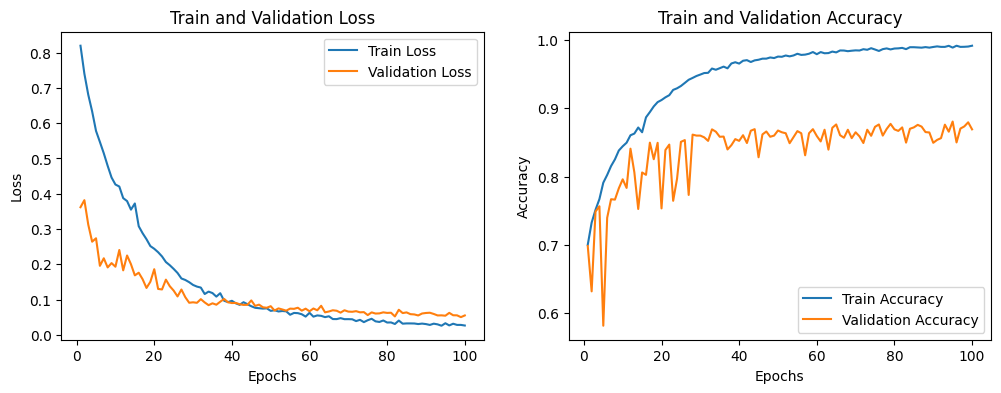

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

So from above we can see that our model does much better than before:
* The training accuracy approaches 1.0 (100%) at the end of the training.
* Wherelese, the validation accuracy fluctuates but ends around 0.86 (86%).

# Testing the model:-

**Let's first test our model on a single image picked randomly.**

/tmp/ipykernel_30/3020517046.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8765


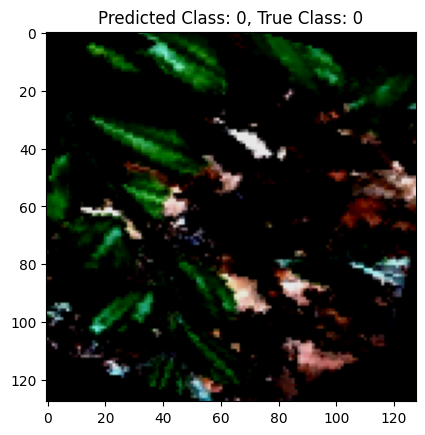

Predicted Class: 0
True Class: 0


In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Create test loader (assumes a function `create_dataloader` exists)
test_loader = create_dataloader(loader_type='test')

# Evaluate model on the test set
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get predictions
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Choose a random image from the test loader and plot it
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() to get a batch

# Randomly select an image from the batch
random_index = np.random.randint(0, len(images))
image = images[random_index]
label = labels[random_index]

# Move the image to the appropriate device and make prediction
image_tensor = image.unsqueeze(0).to(device)
output = model(image_tensor)
_, predicted_class = output.max(1)

# Convert image to CPU and detach for plotting
image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy array for plotting
image = np.clip(image, 0, 1)  # Normalize pixel values for display

# Plot the image
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class.item()}, True Class: {label.item()}')
plt.show()

# Print the predicted class
print(f"Predicted Class: {predicted_class.item()}")
print(f"True Class: {label.item()}")

**Now, let's test on a batch of images picked randomly.**

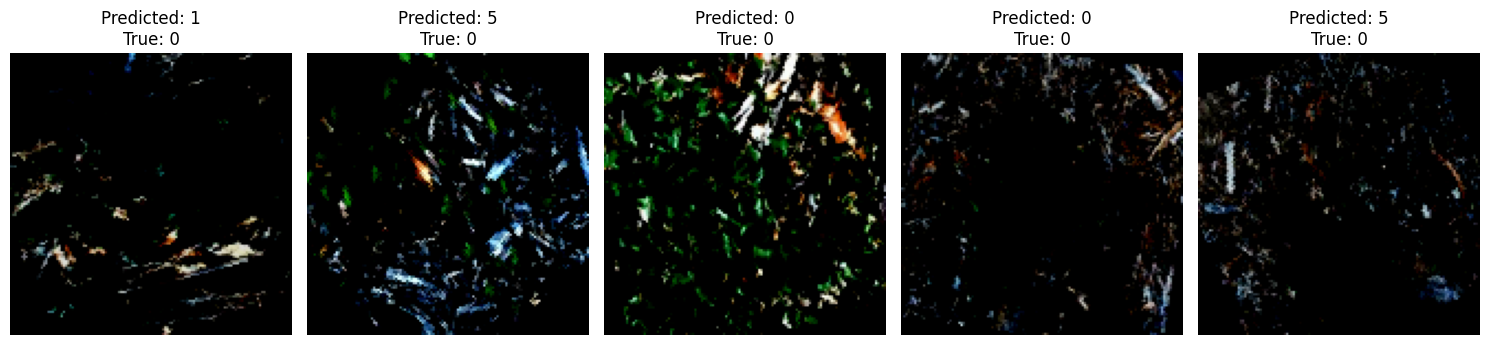

Image 1:
    Predicted Class: 1
    True Class: 0
Image 2:
    Predicted Class: 5
    True Class: 0
Image 3:
    Predicted Class: 0
    True Class: 0
Image 4:
    Predicted Class: 0
    True Class: 0
Image 5:
    Predicted Class: 5
    True Class: 0


In [ ]:
# Evaluate the model on a batch of test images

dataiter = iter(test_loader)
images, labels = next(dataiter)  # Get a batch of images and their labels

# Move images and labels to the appropriate device
images, labels = images.to(device), labels.to(device)

# Make predictions on the batch
outputs = model(images)
_, predicted_classes = outputs.max(1)

# Convert images back to CPU for visualization
images = images.cpu().numpy().transpose((0, 2, 3, 1))  # Convert to numpy array (N, H, W, C)
images = np.clip(images, 0, 1)  # Normalize pixel values for display

# Plot multiple images with their predicted and true labels
num_images_to_plot = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for idx in range(num_images_to_plot):
    axes[idx].imshow(images[idx])
    axes[idx].set_title(
        f"Predicted: {predicted_classes[idx].item()}\nTrue: {labels[idx].item()}"
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print predictions and true labels for the displayed images
for idx in range(num_images_to_plot):
    print(f"Image {idx + 1}:")
    print(f"    Predicted Class: {predicted_classes[idx].item()}")
    print(f"    True Class: {labels[idx].item()}")